In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
# Gradient Boosting 
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
#feed dorward NN
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib as mpl
mpl.rc('image', cmap='copper')
import matplotlib.pyplot as plt
import tensorflow.random as tf_r

# default font
plt.rcParams['font.size'] = 14

2023-04-05 11:05:03.495151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 11:05:03.640696: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-05 11:05:03.640714: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-05 11:05:04.546093: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
# XGBoost 
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree
print("XGBoost version:",xgboost.__version__)

XGBoost version: 1.7.3


# Generate the dataset

We generate a labeled dataset of two categories

In [22]:
np.random.seed(123)

CASE = 3
perc=0.8
S = 2
N = 4000
N_train = 3750
N_test  = N - N_train
x = S*(2*np.random.rand(N,2)-1)
y = np.zeros(N).astype(int)

for n in range(N):
    if CASE==1:
        if x[n,1]<-0.6 and x[n,0]>-0.2: y[n]=1
        if x[n,1]>0.4 and x[n,0]<-0.8: y[n]=1
        if x[n,1]>1.0 and x[n,0]>0.8: y[n]=1
    elif CASE==2:
        if x[n,1]<0 and x[n,0]>0.5: y[n]=1
        if x[n,1]>0 and np.sqrt((x[n,0]+0.3)**2+x[n,1]**2)<1.5: y[n]=1
    elif CASE==3:
        if x[n,1]<-0.5 and x[n,0]>-0: y[n]=1
        if x[n,1]>(x[n,0] +2) and x[n,0]<0: y[n]=1

x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]
print("Train:",len(x_train),"\t Validation:",len(x_test))

Train: 3750 	 Validation: 250


[ 0.78587674 -0.85544266] 1
[-1.09259419  0.20525908] 0
[ 0.87787588 -0.30757416] 0
[1.92305679 0.73931895] 0
[-0.07627239 -0.43152993] 0


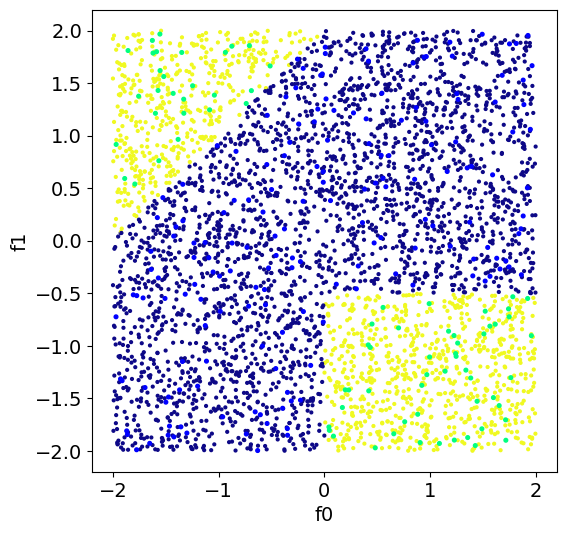

In [23]:
def scat(x,y,s=4,cmap="plasma"):
    plt.scatter(x[:,0],x[:,1],s=s,c=y,cmap=cmap)
    plt.xlabel("f0")
    plt.ylabel("f1")

for n in range(5):
    print(x[n],y[n])

plt.figure(figsize=(6,6))
scat(x_train,y_train)
scat(x_test,y_test,cmap="winter",s=7)
plt.show()

# XG Boost

In [20]:
def classify(clf=GradientBoostingClassifier(),show=False):
    # GradientBoostingClassifier():
    #   n_estimators = 100 (default)
    #   loss function = deviance(default) used in Logistic Regression
    # XGBClassifier()
    #   n_estimators = 100 (default)
    #   max_depth = 3 (default)
    clf.fit(x_train,y_train)
    y_hat = clf.predict(x_test)
    
    if CASE<10: print("errors: {:.2f}%".format(100*(1-clf.score(x_test, y_test))))

    dx = 0.02
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,2))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot= clf.predict(x_plot)

    plt.figure(figsize=(6,6))
    plt.title(str(clf))

    scat(x_plot,y_plot,cmap="winter",s=1)
    scat(x_train,y_train,s=7)
    plt.show()
    
    if show:      
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(3,1,figsize=(30, 30))
        for i in range(min(3,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=300, pad_inches=0.02)   
        plt.show()

### Classify
If the “objective” hyperparameter is left unspecified, XGBClassifier looks at the data and chooses automatically the loss functions and the evaluation metrics (--> WARNING)

errors: 0.80%


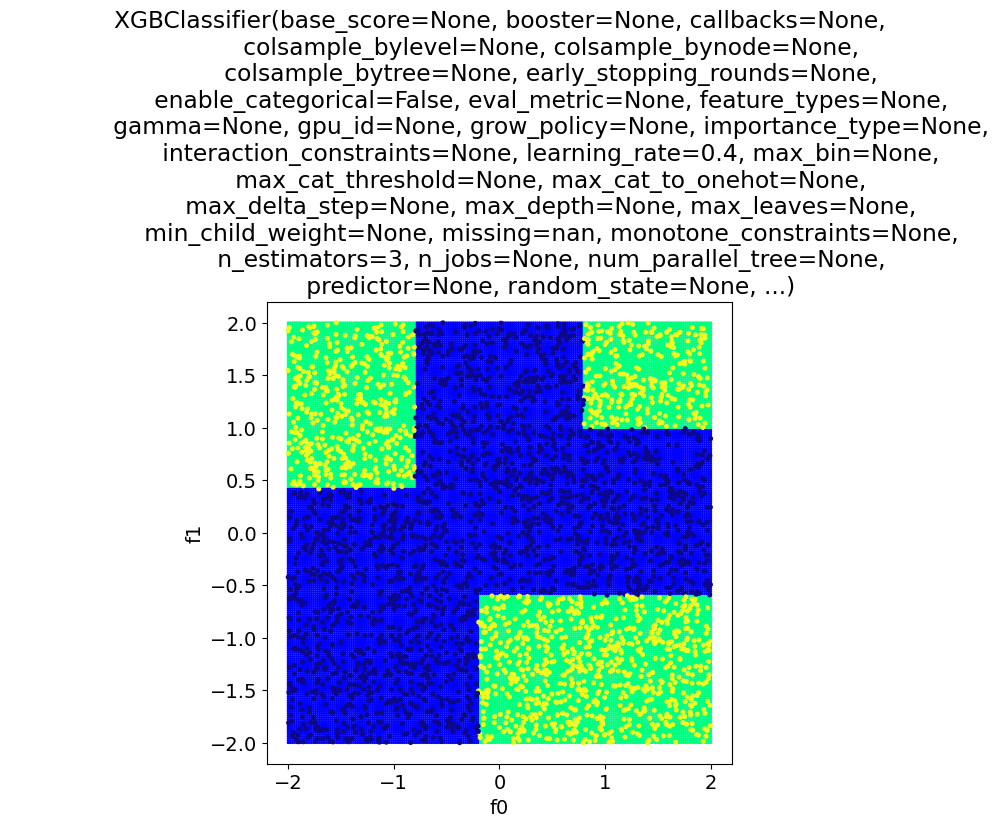

num_trees= 3


ImportError: You must install graphviz to plot tree

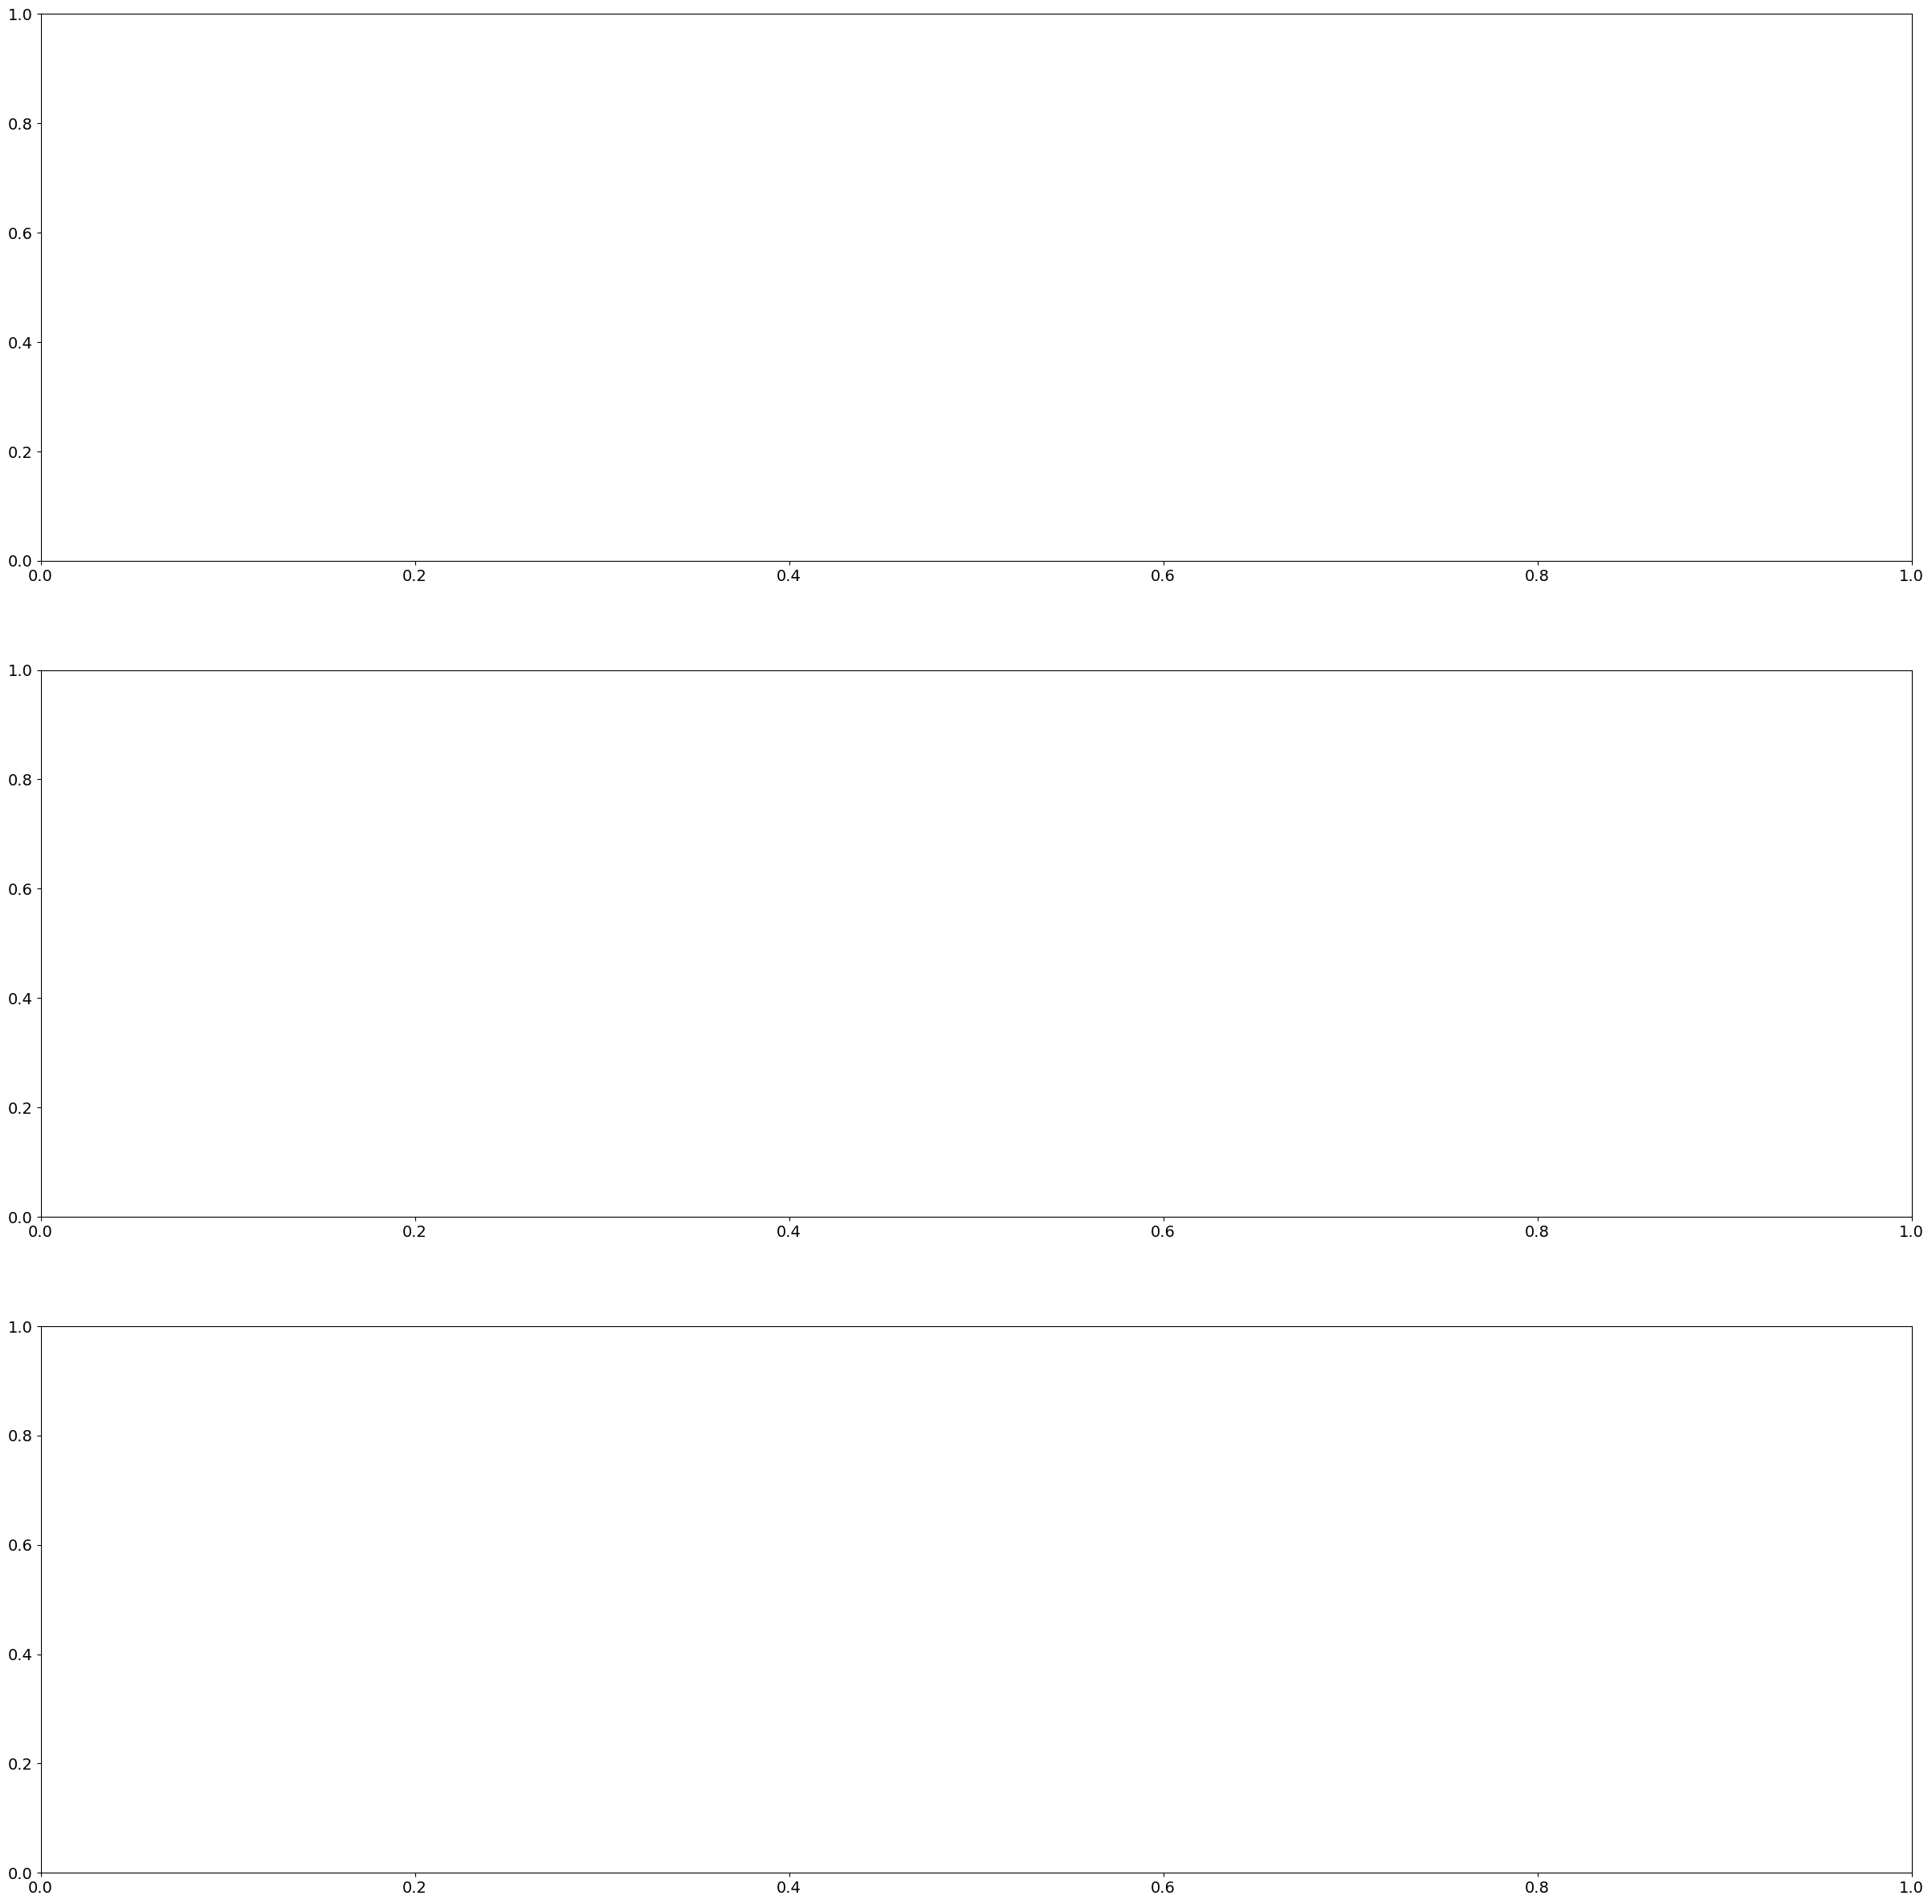

In [21]:
classify(XGBClassifier(seed=1,
                       objective='binary:logistic',
                       #objective="reg:squarederror",eval_metric="rmse",
                       learning_rate=0.4,
                       reg_lambda=0.001, n_estimators=3),show=True)

In [ ]:
# GradientBoostingClassifier():
classify()

# Feed-forward neural network

In [8]:
np.random.seed(12345)
tf_r.set_seed(12345)
L = len(x[0])

In [9]:
def create_model(activation='relu',optimizer=keras.optimizers.Adam()):
    model = Sequential()
    model.add(Dense(L,input_shape=(L,),activation=activation))
    model.add(Dense(20,activation=activation))
    model.add(Dense(20,activation=activation))
    model.add(Dense(20,activation=activation))
    model.add(Dropout(0.01))
    model.add(Dense(1,activation='sigmoid'))
    nepoch=400
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,           #optimization method and cost function
                  metrics=['accuracy'])
    return model


In [10]:
model_DNN = create_model()
print(model_DNN.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 6         
                                                                 
 dense_1 (Dense)             (None, 20)                60        
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 927
Trainable params: 927
Non-trainable pa

2023-04-05 11:05:12.059519: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-05 11:05:12.059576: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-05 11:05:12.059618: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (utente-HP-250-G6-Notebook-PC): /proc/driver/nvidia/version does not exist
2023-04-05 11:05:12.060222: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
fit = model_DNN.fit(x_train, y_train,
               epochs = 400, batch_size = 50,
               verbose=2)

Epoch 1/400
75/75 - 1s - loss: 0.6444 - accuracy: 0.6776 - 701ms/epoch - 9ms/step
Epoch 2/400
75/75 - 0s - loss: 0.5286 - accuracy: 0.7373 - 127ms/epoch - 2ms/step
Epoch 3/400
75/75 - 0s - loss: 0.4258 - accuracy: 0.7608 - 131ms/epoch - 2ms/step
Epoch 4/400
75/75 - 0s - loss: 0.3464 - accuracy: 0.8056 - 128ms/epoch - 2ms/step
Epoch 5/400
75/75 - 0s - loss: 0.2679 - accuracy: 0.9099 - 120ms/epoch - 2ms/step
Epoch 6/400
75/75 - 0s - loss: 0.2037 - accuracy: 0.9299 - 115ms/epoch - 2ms/step
Epoch 7/400
75/75 - 0s - loss: 0.1465 - accuracy: 0.9528 - 119ms/epoch - 2ms/step
Epoch 8/400
75/75 - 0s - loss: 0.1126 - accuracy: 0.9627 - 125ms/epoch - 2ms/step
Epoch 9/400
75/75 - 0s - loss: 0.0877 - accuracy: 0.9723 - 164ms/epoch - 2ms/step
Epoch 10/400
75/75 - 0s - loss: 0.0765 - accuracy: 0.9728 - 146ms/epoch - 2ms/step
Epoch 11/400
75/75 - 0s - loss: 0.0724 - accuracy: 0.9752 - 166ms/epoch - 2ms/step
Epoch 12/400
75/75 - 0s - loss: 0.0648 - accuracy: 0.9773 - 149ms/epoch - 2ms/step
Epoch 13/400


Epoch 100/400
75/75 - 0s - loss: 0.0153 - accuracy: 0.9928 - 112ms/epoch - 1ms/step
Epoch 101/400
75/75 - 0s - loss: 0.0119 - accuracy: 0.9963 - 128ms/epoch - 2ms/step
Epoch 102/400
75/75 - 0s - loss: 0.0133 - accuracy: 0.9955 - 116ms/epoch - 2ms/step
Epoch 103/400
75/75 - 0s - loss: 0.0122 - accuracy: 0.9957 - 122ms/epoch - 2ms/step
Epoch 104/400
75/75 - 0s - loss: 0.0146 - accuracy: 0.9939 - 119ms/epoch - 2ms/step
Epoch 105/400
75/75 - 0s - loss: 0.0142 - accuracy: 0.9944 - 124ms/epoch - 2ms/step
Epoch 106/400
75/75 - 0s - loss: 0.0121 - accuracy: 0.9955 - 107ms/epoch - 1ms/step
Epoch 107/400
75/75 - 0s - loss: 0.0162 - accuracy: 0.9920 - 112ms/epoch - 1ms/step
Epoch 108/400
75/75 - 0s - loss: 0.0121 - accuracy: 0.9952 - 128ms/epoch - 2ms/step
Epoch 109/400
75/75 - 0s - loss: 0.0116 - accuracy: 0.9965 - 118ms/epoch - 2ms/step
Epoch 110/400
75/75 - 0s - loss: 0.0112 - accuracy: 0.9968 - 126ms/epoch - 2ms/step
Epoch 111/400
75/75 - 0s - loss: 0.0165 - accuracy: 0.9939 - 112ms/epoch - 1

Epoch 198/400
75/75 - 0s - loss: 0.0110 - accuracy: 0.9941 - 116ms/epoch - 2ms/step
Epoch 199/400
75/75 - 0s - loss: 0.0222 - accuracy: 0.9912 - 113ms/epoch - 2ms/step
Epoch 200/400
75/75 - 0s - loss: 0.0076 - accuracy: 0.9984 - 116ms/epoch - 2ms/step
Epoch 201/400
75/75 - 0s - loss: 0.0088 - accuracy: 0.9957 - 121ms/epoch - 2ms/step
Epoch 202/400
75/75 - 0s - loss: 0.0100 - accuracy: 0.9957 - 116ms/epoch - 2ms/step
Epoch 203/400
75/75 - 0s - loss: 0.0144 - accuracy: 0.9941 - 116ms/epoch - 2ms/step
Epoch 204/400
75/75 - 0s - loss: 0.0156 - accuracy: 0.9931 - 117ms/epoch - 2ms/step
Epoch 205/400
75/75 - 0s - loss: 0.0102 - accuracy: 0.9960 - 118ms/epoch - 2ms/step
Epoch 206/400
75/75 - 0s - loss: 0.0110 - accuracy: 0.9949 - 112ms/epoch - 1ms/step
Epoch 207/400
75/75 - 0s - loss: 0.0097 - accuracy: 0.9968 - 112ms/epoch - 1ms/step
Epoch 208/400
75/75 - 0s - loss: 0.0136 - accuracy: 0.9949 - 113ms/epoch - 2ms/step
Epoch 209/400
75/75 - 0s - loss: 0.0122 - accuracy: 0.9955 - 118ms/epoch - 2

Epoch 296/400
75/75 - 0s - loss: 0.0083 - accuracy: 0.9960 - 116ms/epoch - 2ms/step
Epoch 297/400
75/75 - 0s - loss: 0.0082 - accuracy: 0.9960 - 136ms/epoch - 2ms/step
Epoch 298/400
75/75 - 0s - loss: 0.0073 - accuracy: 0.9976 - 147ms/epoch - 2ms/step
Epoch 299/400
75/75 - 0s - loss: 0.0076 - accuracy: 0.9965 - 137ms/epoch - 2ms/step
Epoch 300/400
75/75 - 0s - loss: 0.0077 - accuracy: 0.9971 - 118ms/epoch - 2ms/step
Epoch 301/400
75/75 - 0s - loss: 0.0094 - accuracy: 0.9963 - 115ms/epoch - 2ms/step
Epoch 302/400
75/75 - 0s - loss: 0.0070 - accuracy: 0.9971 - 126ms/epoch - 2ms/step
Epoch 303/400
75/75 - 0s - loss: 0.0070 - accuracy: 0.9968 - 107ms/epoch - 1ms/step
Epoch 304/400
75/75 - 0s - loss: 0.0106 - accuracy: 0.9947 - 143ms/epoch - 2ms/step
Epoch 305/400
75/75 - 0s - loss: 0.0089 - accuracy: 0.9965 - 119ms/epoch - 2ms/step
Epoch 306/400
75/75 - 0s - loss: 0.0068 - accuracy: 0.9976 - 116ms/epoch - 2ms/step
Epoch 307/400
75/75 - 0s - loss: 0.0090 - accuracy: 0.9955 - 119ms/epoch - 2

Epoch 394/400
75/75 - 0s - loss: 0.0093 - accuracy: 0.9968 - 120ms/epoch - 2ms/step
Epoch 395/400
75/75 - 0s - loss: 0.0110 - accuracy: 0.9952 - 114ms/epoch - 2ms/step
Epoch 396/400
75/75 - 0s - loss: 0.0176 - accuracy: 0.9941 - 116ms/epoch - 2ms/step
Epoch 397/400
75/75 - 0s - loss: 0.0071 - accuracy: 0.9973 - 124ms/epoch - 2ms/step
Epoch 398/400
75/75 - 0s - loss: 0.0083 - accuracy: 0.9968 - 123ms/epoch - 2ms/step
Epoch 399/400
75/75 - 0s - loss: 0.0084 - accuracy: 0.9965 - 114ms/epoch - 2ms/step
Epoch 400/400
75/75 - 0s - loss: 0.0094 - accuracy: 0.9963 - 114ms/epoch - 2ms/step


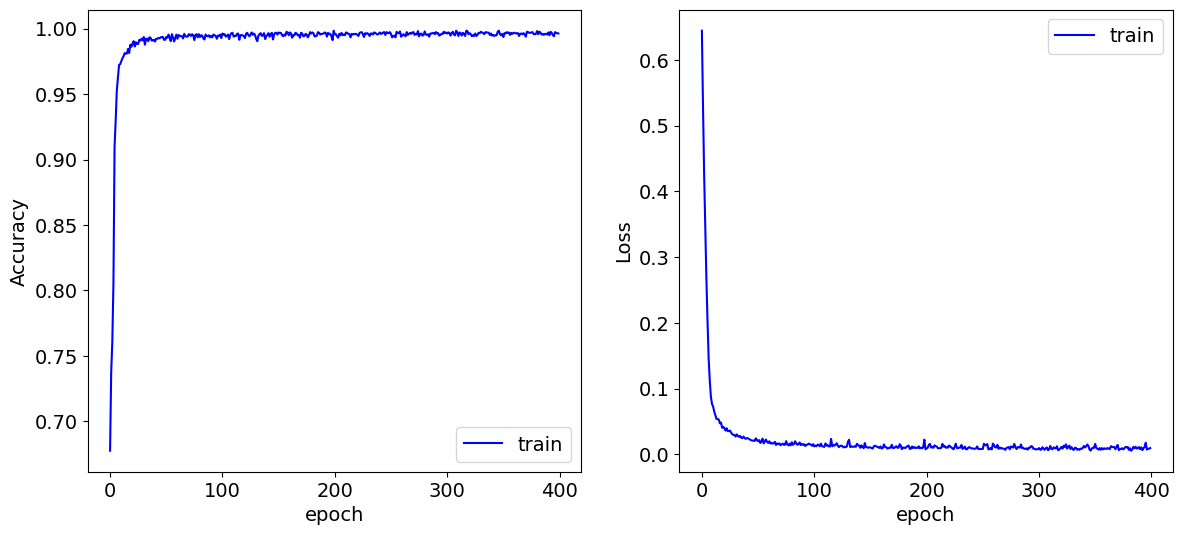

In [12]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(fit.history['accuracy'],label="train",c="b")
#ax.plot(fit.history['val_accuracy'],label="test.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()
ax=AX[1]
ax.plot(fit.history['loss'],label="train",c="b")
#ax.plot(fit.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

In [17]:
y_hat_NN = model_DNN.predict(x_test)

count=0
for i in range(len(y_hat_NN)):
    if y_hat_NN[i] < 0.5: y_hat_NN[i]=0
    else: y_hat_NN[i]=1
    if y_hat_NN[i]!=y_test[i]: count+=1
print(count/len(y_hat_NN)*100)

8/8 [==============================] - 0s 2ms/step
0.0


In [14]:
score=model_DNN.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

8/8 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 1.0000
Test loss: 0.0023291383404284716
Test accuracy: 1.0


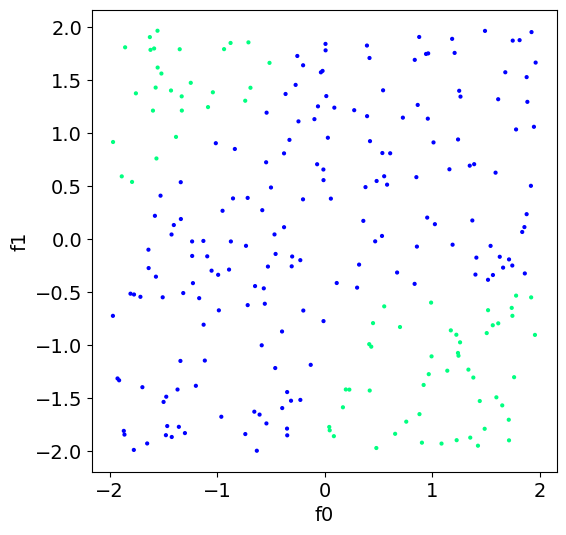

In [15]:
plt.figure(figsize=(6,6))
scat(x_test,y_hat_NN,cmap="winter",s=4)
#scat(x_test,y_test,cmap="winter",s=4)
plt.show()

In [28]:
perc=np.array([[1.45,0.65],[1,0.4],[1.3,0.2],[1.2,0.8]])
df_results = pd.DataFrame(perc,index=['0.5', '0.63','0.75','0.89'], columns=['XGBoost','NN'])

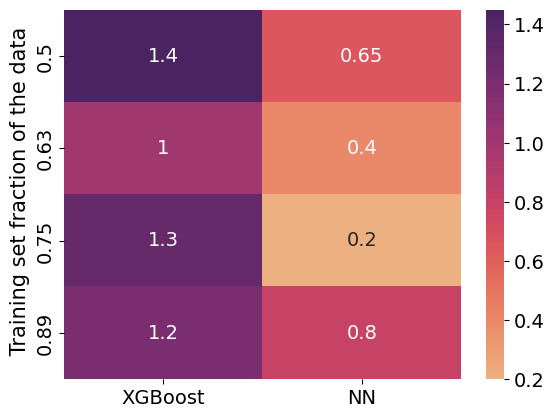

In [40]:
s = sns.heatmap(df_results, cmap='flare', annot=True)
s.set_ylabel(' Training set fraction of the data', fontsize=15)
#s.set_ylabel('optimizer', fontsize=15)
plt.yticks(rotation=90) 
plt.show()

# Try different parameters (λ, γ, n_estimators, …)

In [ ]:
l_rates=[0.04,0.4,1]
reg_lambdas=[0.01,0.001,0.0001]
nums_estimators=[2,3,4]
for learning_rate in l_rates:
    classify(XGBClassifier(seed=42,
                           objective='binary:logistic',
                           #objective="reg:squarederror",eval_metric="rmse",
                           learning_rate=learning_rate,
                           reg_lambda=0.001, n_estimators=3),show=False)